In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('Data_Wind.csv')

In [3]:
df['index'] = pd.to_datetime(df['index'])

df['year'] = df['index'].dt.year
df['month'] = df['index'].dt.month
df['day'] = df['index'].dt.day
df['hour'] = df['index'].dt.hour
df = df.drop('index', axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58496 entries, 0 to 58495
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   site                      58496 non-null  int64  
 1   ActivePower_value_KWh     58496 non-null  float64
 2   AmbientTemperature_value  58496 non-null  float64
 3   NacelleAngle_value        58496 non-null  float64
 4   RotorSpeed_value          58496 non-null  float64
 5   WindDirection_value       58496 non-null  float64
 6   WindSpeed_value           58429 non-null  float64
 7   year                      58496 non-null  int32  
 8   month                     58496 non-null  int32  
 9   day                       58496 non-null  int32  
 10  hour                      58496 non-null  int32  
dtypes: float64(6), int32(4), int64(1)
memory usage: 4.0 MB


In [4]:
nulos = df.isnull().sum()

# Mostrar cuántos valores nulos hay por columna
print(nulos)

site                         0
ActivePower_value_KWh        0
AmbientTemperature_value     0
NacelleAngle_value           0
RotorSpeed_value             0
WindDirection_value          0
WindSpeed_value             67
year                         0
month                        0
day                          0
hour                         0
dtype: int64


In [5]:
df['WindSpeed_value'] = df['WindSpeed_value'].fillna(df['WindSpeed_value'].mean())

In [6]:
nulos = df.isnull().sum()

# Mostrar cuántos valores nulos hay por columna
print(nulos)

site                        0
ActivePower_value_KWh       0
AmbientTemperature_value    0
NacelleAngle_value          0
RotorSpeed_value            0
WindDirection_value         0
WindSpeed_value             0
year                        0
month                       0
day                         0
hour                        0
dtype: int64


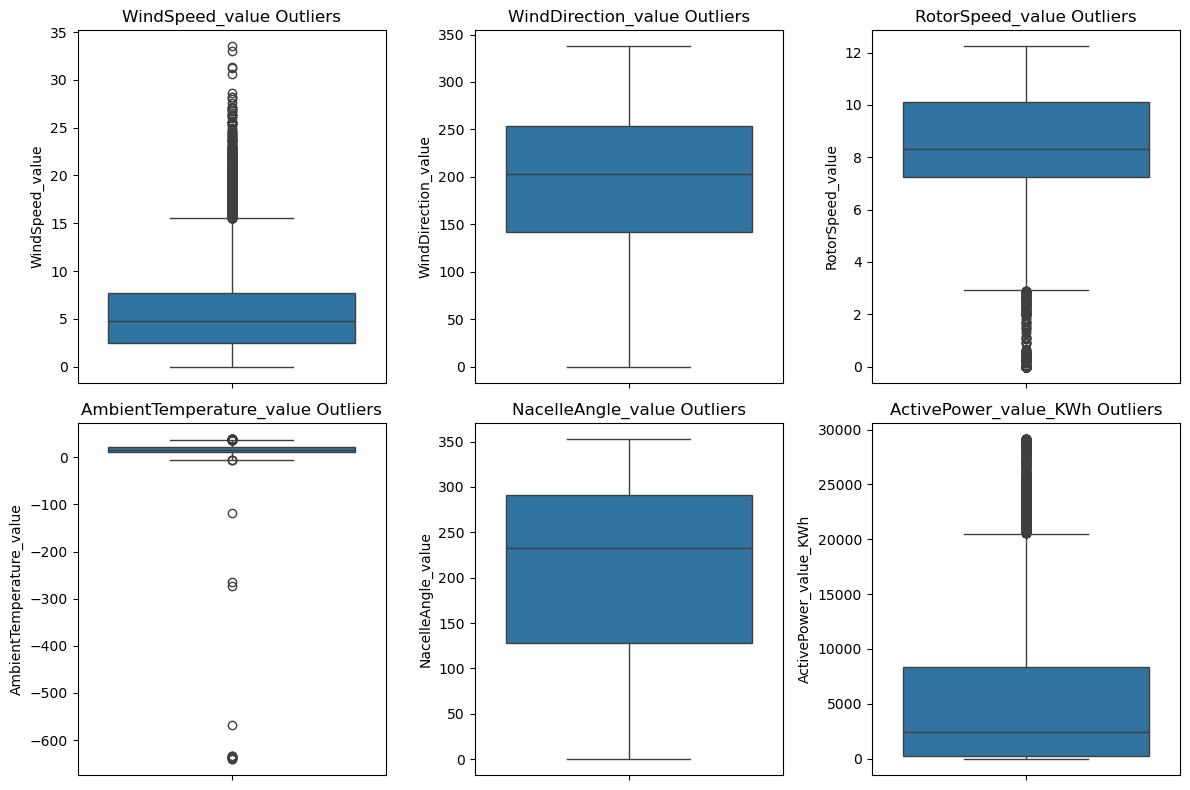

In [7]:
variables = ['WindSpeed_value', 'WindDirection_value', 'RotorSpeed_value', 
             'AmbientTemperature_value', 'NacelleAngle_value', 'ActivePower_value_KWh']

# Boxplot para detectar outliers
plt.figure(figsize=(12, 8))
for i, var in enumerate(variables, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(data=df, y=var)
    plt.title(f'{var} Outliers')
plt.tight_layout()
plt.show()

In [8]:
# 2. Imputar valores atípicos con la media
for var in variables:
    Q1 = df[var].quantile(0.25)
    Q3 = df[var].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[var] = df[var].apply(lambda x: df[var].mean() if x < lower_bound or x > upper_bound else x)

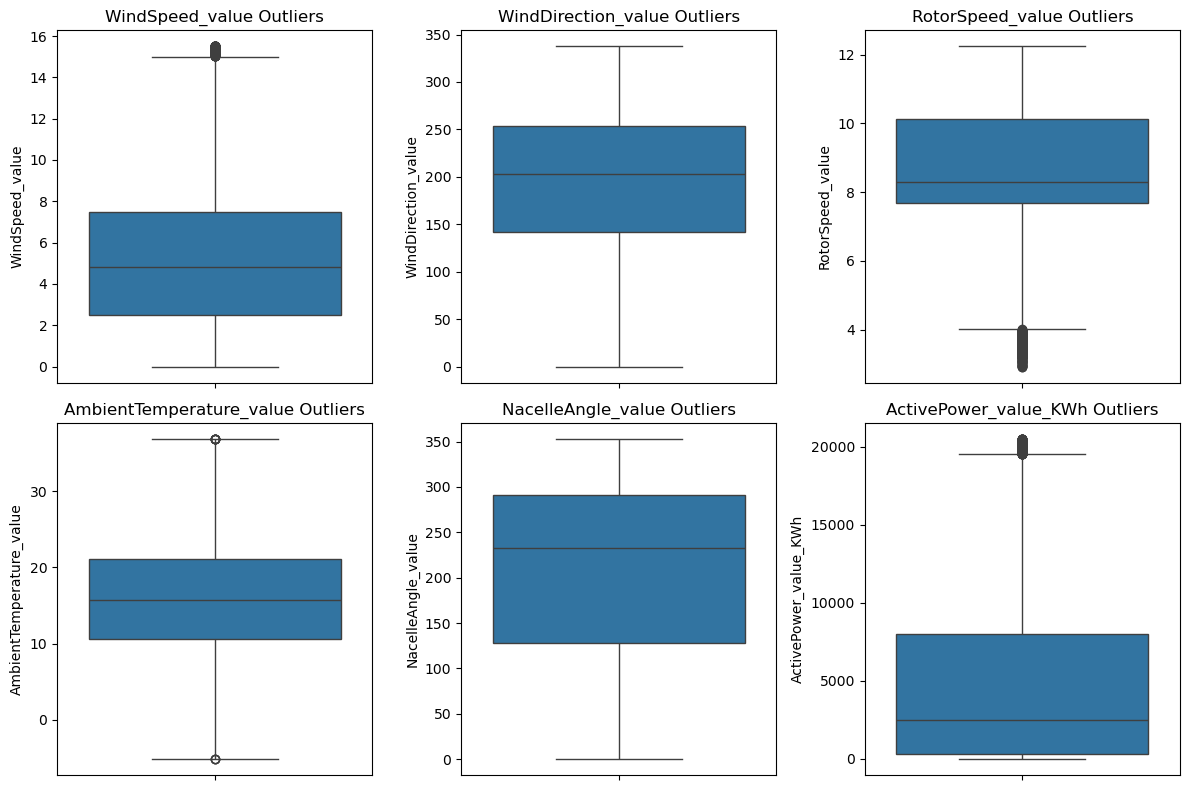

In [9]:
plt.figure(figsize=(12, 8))
for i, var in enumerate(variables, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(data=df, y=var)
    plt.title(f'{var} Outliers')
plt.tight_layout()
plt.show()

In [10]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError
#import joblib

In [12]:
X_ker = df[['WindSpeed_value', 'WindDirection_value', 'RotorSpeed_value', 
          'AmbientTemperature_value', 'NacelleAngle_value']].values

Y_ker = df['ActivePower_value_KWh'].values

kf = KFold(n_splits=5, shuffle=True, random_state=42)
mse_scores = []
mae_scores = []
r2_scores = []

for train_index, test_index in kf.split(X_ker):
    X_train_ker, X_test_ker = X_ker[train_index], X_ker[test_index]
    Y_train_ker, Y_test_ker = Y_ker[train_index], Y_ker[test_index]
    
    scaler_ker = MinMaxScaler()
    X_train_ker = scaler_ker.fit_transform(X_train_ker)
    X_test_ker = scaler_ker.transform(X_test_ker)
    #joblib.dump(scaler_ker, 'scaler_ker1.pkl')
    
    
    model = Sequential()
    model.add(Dense(128, activation='relu', input_shape=(X_train_ker.shape[1],), kernel_regularizer=l2(0.05)))
    model.add(Dropout(0.3))
    model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.05)))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.05)))
    model.add(Dropout(0.3))
    model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.05)))
    model.add(Dense(1))
   
    
    
    model.compile(optimizer='adam', loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])
    
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    history = model.fit(X_train_ker, Y_train_ker, epochs=100, 
                        batch_size=100, verbose=0,validation_data=(X_test_ker, Y_test_ker), callbacks=[early_stop])
    
    mse, mae = model.evaluate(X_test_ker, Y_test_ker, verbose=0)
    mse_scores.append(mse)
    mae_scores.append(mae)
    
    Y_test_pred = model.predict(X_test_ker, verbose=0)
    r2 = r2_score(Y_test_ker, Y_test_pred)
    r2_scores.append(r2)
  

print("MSE en cada fold:", mse_scores)
print("MSE promedio en validación cruzada:", np.mean(mse_scores))
print("MAE en cada fold:", mae_scores)
print("MAE promedio en validación cruzada:", np.mean(mae_scores))
print("R² en cada fold:", r2_scores)
print("R² promedio en validación cruzada:", np.mean(r2_scores))


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwa

MSE en cada fold: [7147469.0, 7342256.5, 7349954.5, 6933412.0, 7300173.5]
MSE promedio en validación cruzada: 7214653.1
MAE en cada fold: [1636.685791015625, 1675.546142578125, 1670.882080078125, 1627.03173828125, 1676.1029052734375]
MAE promedio en validación cruzada: 1657.2497314453126
R² en cada fold: [0.7241625468059063, 0.725283299151948, 0.7233519263360818, 0.7351552115869033, 0.7255486104949215]
R² promedio en validación cruzada: 0.7267003188751522


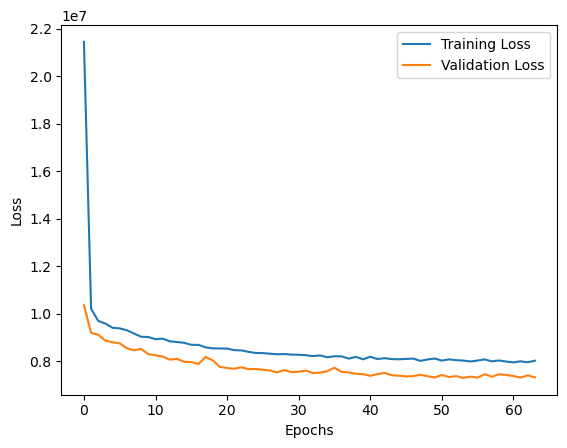

In [13]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()